# Trabalho de Processamento de Linguagem natural

## Criação de um modelo de classificação de comentários

<p> Foi utilizado para este modelo a base de dados disponível em "https://www.kaggle.com/cursostic/avaliao-atendimento"

# 1. Setup do Projeto

In [41]:
import joblib
import os

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm  import SVC
from sklearn.tree import DecisionTreeClassifier

print('Matplot version : {}'.format(matplotlib.__version__))
print('Pandas version : {}'.format(pd.__version__))
print('Sklearn version : {}'.format(sklearn.__version__))

DATA_PATH = os.path.join('..', 'data', 'raw')
DATA_FILE = 'all.csv'
AVAL_DATA = os.path.join(DATA_PATH, DATA_FILE)

!pip install spacy
import spacy
import nltk
import re

Matplot version : 3.3.4
Pandas version : 1.2.4
Sklearn version : 0.24.1


In [2]:
import spacy.cli
spacy.cli.download("pt_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [3]:
import pt_core_news_sm
spacy_pt = pt_core_news_sm.load()

# Passo 2: Recuperação de Dados

In [4]:
def load_data(data_path, data_file):
    local_path = os.path.join(data_path, data_file)
    return pd.read_csv(local_path)

In [5]:
avaliacoes = load_data(DATA_PATH, DATA_FILE)
avaliacoes.rename(columns={'coment':'Comentário','manifest_atendimento':'Classificação'}, inplace=True)

# Passo 3: Análise exploratória de Dados

In [6]:
avaliacoes.head()

,Comentário,Classificação
0,Nunca abri esse incidente,neutro
1,"Profissionais educados, atenciosos e o mais im...",elogio
2,Não tenho condições de responder a esta pesqui...,reclamação
3,Chamado não foi resolvido. Apesar de explicado...,reclamação
4,"O chamado foi encerrado como concluído. Porém,...",reclamação


In [7]:
avaliacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42314 entries, 0 to 42313
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Comentário     42306 non-null  object
 1   Classificação  42314 non-null  object
dtypes: object(2)
memory usage: 661.3+ KB


In [8]:
avaliacoes.isnull().sum()

Comentário       8
Classificação    0
dtype: int64

In [9]:
#removendo comentários vazios
avaliacoes.fillna('', inplace = True)
avaliacoes = avaliacoes[avaliacoes['Comentário'] != '']

In [10]:
#analisando classificacoes
avaliacoes['Classificação'].value_counts()

elogio        27630
neutro         8174
reclamação     6502
Name: Classificação, dtype: int64

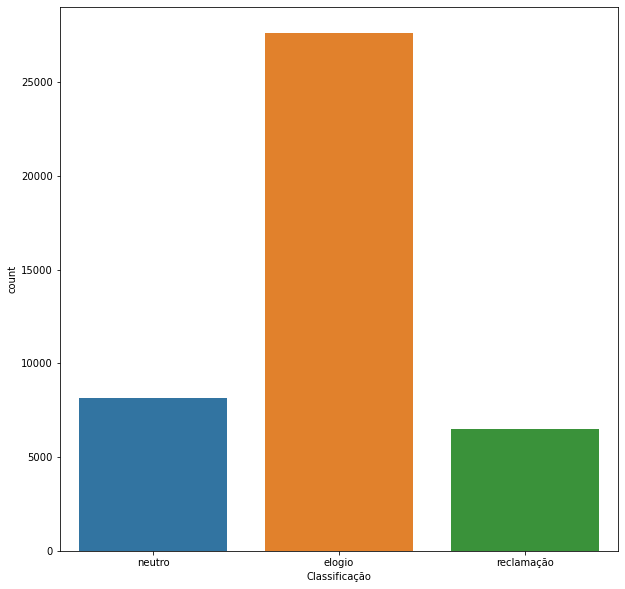

In [11]:
plt.figure(figsize=(10,10))
_ = sns.countplot(x='Classificação',data=avaliacoes)

# Parte 3. Pre-processamento do Texto

In [12]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("portuguese")
import string

[nltk_data] Downloading package stopwords to C:\Users\Tiago
[nltk_data]     Custodio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
stopwords

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

In [14]:
#removendo das stopwords palavras que podem interferir na avaliação
stopwords.remove('não')
stopwords.remove('nem')

In [19]:
#limpando as strings dos comentários
def limpa_comentario(comentario):
    comentario = re.sub(r'\s+',' ',comentario)
    comentario = comentario.lower()
    comentario = [word for word in comentario.split() if word not in stopwords and word not in string.punctuation]
    novo_comentario = spacy_pt(" ".join(comentario))
    tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in novo_comentario]
    return " ".join(tokens)

In [20]:
avaliacoes['Comentário'] = avaliacoes['Comentário'].apply(limpa_comentario)

In [21]:
avaliacoes.head()

,Comentário,Classificação
0,nunca abrir incidente,neutro
1,profissional educar atencioso importante probl...,elogio
2,não condição responder pesquisar onde parecer ...,reclamação
3,chamar não resolver apesar explicar necessidad...,reclamação
4,chamar encerrar concluir porém ramal continuar...,reclamação


In [22]:
avaliacoes[avaliacoes['Comentário']=='']

,Comentário,Classificação
217,,neutro
755,,neutro
756,,neutro
1369,,neutro
3056,,elogio
...,...,...
41125,,neutro
41126,,neutro
41167,,neutro
41320,,neutro


In [23]:
avaliacoes = avaliacoes[avaliacoes['Comentário']!='']

# Passo 4: Extração de recursos

In [24]:
avaliacoes.head()

,Comentário,Classificação
0,nunca abrir incidente,neutro
1,profissional educar atencioso importante probl...,elogio
2,não condição responder pesquisar onde parecer ...,reclamação
3,chamar não resolver apesar explicar necessidad...,reclamação
4,chamar encerrar concluir porém ramal continuar...,reclamação


In [37]:
#usando Bag of Words
vectorizer = CountVectorizer(binary=True, max_features=5000)
texto = avaliacoes['Comentário']
bow = vectorizer.fit_transform(texto)

In [27]:
bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [28]:
print('Shape: ',bow.shape, '\nTipo: ', type(bow))

Shape:  (42213, 5000) 
Tipo:  <class 'scipy.sparse.csr.csr_matrix'>


In [38]:
#usando TF-IDF
tf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf = tf_vectorizer.fit_transform(texto)
print(tfidf)

  (0, 2509)	0.5805928052076192
  (0, 235)	0.4698655041777356
  (0, 3244)	0.6649348859286524
  (1, 3275)	0.21968721328427196
  (1, 3414)	0.22445854634609802
  (1, 1784)	0.42148139371809
  (1, 4130)	0.1901495229514199
  (1, 3725)	0.18151859696852513
  (1, 2452)	0.4259430128459313
  (1, 606)	0.257412072406106
  (1, 1670)	0.3109847734894037
  (1, 3748)	0.5569591792600587
  (2, 3167)	0.28071730357915375
  (2, 4327)	0.1277075907536867
  (2, 3566)	0.15219145193354253
  (2, 732)	0.23165925538185508
  (2, 548)	0.18622691802697397
  (2, 562)	0.21631974187692088
  (2, 1708)	0.31291373412290036
  (2, 3801)	0.29056398879505796
  (2, 531)	0.18183090390796341
  (2, 3057)	0.18551035816572944
  (2, 1323)	0.1508638481625385
  (2, 4498)	0.1386483376902877
  (2, 1982)	0.20912473094231088
  :	:
  (42206, 1692)	0.4004443122776874
  (42206, 1788)	0.3657844711516301
  (42207, 4276)	0.71069304801265
  (42207, 2090)	0.7035022327658165
  (42208, 2160)	0.5051565024141965
  (42208, 3163)	0.39369099865600643
  (422

# Passo 5: Treinamento dos Modelos

In [40]:
#dados Bag of words
x_bow_train, x_bow_test, y_bow_train, y_bow_test = train_test_split(bow, avaliacoes['Classificação'], random_state=42)

#dados TF-IDF
x_td_train, x_td_test, y_td_train, y_td_test = train_test_split(tfidf, avaliacoes['Classificação'], random_state=42)

In [51]:
def build_classifiers():
    
    classifiers = []
    classifiers.append(
        ('knn',
        KNeighborsClassifier(),
        {'n_neighbors': range(1, 33, 2)})
    )
    
    classifiers.append(
        ('lr',
        LogisticRegression(max_iter=100),
        {'penalty': ['l2'], 'C': [100,10,1, 0.1,0.01]})
    )
    
    classifiers.append(
        ('dt',
        DecisionTreeClassifier(),
        {'max_depth': [2,4,6,8,10,12]})
    )
    
    classifiers.append(
        ('rf',
        RandomForestClassifier(),
        {'n_estimators': [10,50,100]})
    )
    
    return classifiers

In [52]:
classifiers = build_classifiers()

In [53]:
#analisando resultados bag of words
results = []
names = []
for name, model, parameters in classifiers:
    print(">> Classifier name: {}".format(name))
    gs = GridSearchCV(estimator=model,param_grid=parameters,refit=True, verbose=0)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv = cross_val_score(gs, x_bow_train, y_bow_train, cv=kf, scoring='accuracy')
    print('Mean: {}, Standart Deviation: {}'.format(cv.mean(),cv.std()))
    results.append(cv)
    names.append(name)

>> Classifier name: knn
Mean: 0.7882118870206495, Standart Deviation: 0.005833344365698841
>> Classifier name: lr


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Mean: 0.840835252699244, Standart Deviation: 0.004171412359095956
>> Classifier name: dt
Mean: 0.7540037325983616, Standart Deviation: 0.0031175333375206104
>> Classifier name: rf
Mean: 0.8376449627234079, Standart Deviation: 0.002575891201260911


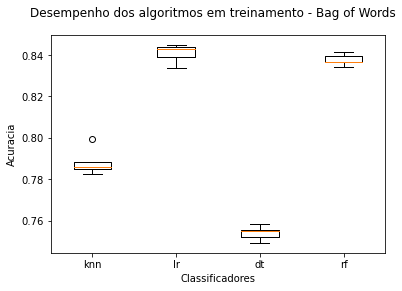

In [54]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos em treinamento - Bag of Words')
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_xlabel('Classificadores')
ax.set_ylabel('Acuracia')
plt.show()

In [55]:
#analisando resultados de treino TF-IDF
results = []
names = []
for name, model, parameters in classifiers:
    print(">> Classifier name: {}".format(name))
    gs = GridSearchCV(estimator=model,param_grid=parameters,refit=True, verbose=0)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv = cross_val_score(gs, x_td_train, y_td_train, cv=kf, scoring='accuracy')
    print('Mean: {}, Standart Deviation: {}'.format(cv.mean(),cv.std()))
    results.append(cv)
    names.append(name)

>> Classifier name: knn
Mean: 0.7306611133356675, Standart Deviation: 0.009456314264362213
>> Classifier name: lr


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Mean: 0.847152571654304, Standart Deviation: 0.0032692201485203967
>> Classifier name: dt
Mean: 0.7521084570872423, Standart Deviation: 0.002107055311307585
>> Classifier name: rf
Mean: 0.838939947253899, Standart Deviation: 0.004115354722173504


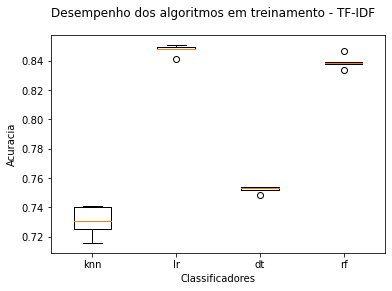

In [56]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos em treinamento - TF-IDF')
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_xlabel('Classificadores')
ax.set_ylabel('Acuracia')
plt.show()

# Passo 6: Testar os modelos

In [ ]:
#Bag of Words
classifiers = build_classifiers()
test_results = []
names = []

for name, model, parameters in classifiers:
    gs = GridSearchCV(estimator=model,param_grid=parameters, refit=True, verbose=0)
    gs.fit(x_bow_train,y_bow_train)
    y_bow_pred = gs.predict(x_bow_test)
    test_accuracy = gs.score(x_bow_test, y_bow_test)
    print("Acurácia do modelo {} em Teste: {}".format(name,test_accuracy))
    print(classification_report(y_bow_test,y_bow_pred))
    names.append(name)
    test_results.append(test_accuracy)

In [ ]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos em Teste - Bag of Words')
ax.set_xlabel('Classificadores')
ax.set_ylabel('Acurácia')
_ = sns.barplot(names, test_results)

In [ ]:
#TF-IDF
classifiers = build_classifiers()
test_results = []
names = []

for name, model, parameters in classifiers:
    gs = GridSearchCV(estimator=model,param_grid=parameters, refit=True, verbose=0)
    gs.fit(x_td_train,y_td_train)
    y_td_pred = gs.predict(x_td_test)
    test_accuracy = gs.score(x_td_test, y_td_test)
    print("Acurácia do modelo {} em Teste: {}".format(name,test_accuracy))
    print(classification_report(y_td_test,y_td_pred))
    names.append(name)
    test_results.append(test_accuracy)

In [ ]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos em Teste - TF-IDF')
ax.set_xlabel('Classificadores')
ax.set_ylabel('Acurácia')
_ = sns.barplot(names, test_results)

# Passo 7: Deploy do modelo

In [70]:
#de acordo com as informações obtidas será usado o Logistic Regression
DEPLOY_PATH = os.path.join('..','app','model')
DEPLOY_MODEL = 'finalized_model.sav'
DEPLOY_VECTORIZER = 'vetorizador.joblib'

model = LogisticRegression(max_iter=1000, C = 1, penalty = 'l2')
model.fit(x_td_train, y_td_train)

model_path = os.path.join(DEPLOY_PATH, DEPLOY_MODEL)
vectorizer_path = os.path.join(DEPLOY_PATH, DEPLOY_VECTORIZER)
joblib.dump(model, model_path)
joblib.dump(tf_vectorizer, vectorizer_path)

['..\\app\\model\\vetorizador.joblib']